In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('drive/MyDrive/Bert/data/train.csv')
df.head()

,ID,Utterance,Speaker,Dialogue_ID,Target
0,TRAIN_0000,also I was the point person on my company’s tr...,Chandler,0,neutral
1,TRAIN_0001,You must’ve had your hands full.,The Interviewer,0,neutral
2,TRAIN_0002,That I did. That I did.,Chandler,0,neutral
3,TRAIN_0003,So let’s talk a little bit about your duties.,The Interviewer,0,neutral
4,TRAIN_0004,My duties? All right.,Chandler,0,surprise


In [ ]:
df = df.drop(columns=['ID','Speaker',"Dialogue_ID"])
df

,Utterance,Target
0,also I was the point person on my company’s tr...,neutral
1,You must’ve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So let’s talk a little bit about your duties.,neutral
4,My duties? All right.,surprise
...,...,...
9984,You or me?,neutral
9985,"I got it. Uh, Joey, women don't have Adam's ap...",neutral
9986,"You guys are messing with me, right?",surprise
9987,Yeah.,neutral


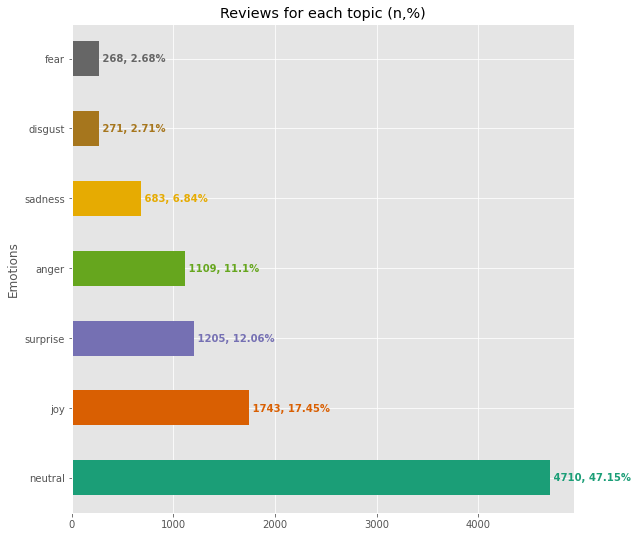

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

num_classes = len(df['Target'].value_counts())

colors = plt.cm.Dark2(np.linspace(0,1,num_classes))
iter_color = iter(colors)

df['Target'].value_counts().plot.barh(title = "Reviews for each topic (n,%)",
                                      ylabel = "Emotions",
                                      color = colors,
                                      figsize = (9,9))

for i, v in enumerate(df['Target'].value_counts()):
    c = next(iter_color)
    plt.text(v,i,
             " "+str(v)+", "+str(round(v*100/df.shape[0],2))+"%",
             color = c,
             va = 'center',
             fontweight = 'bold')

In [ ]:
# map emotions

df['Labels'] = df['Target'].map({'neutral':0,
                                 'joy':1,
                                 'surprise':2,
                                 'anger':3,
                                 'sadness':4,
                                 'disgust':5,
                                 'fear':6})

df = df.drop(['Target'], axis = 1)
df.head()

,Utterance,Labels
0,also I was the point person on my company’s tr...,0
1,You must’ve had your hands full.,0
2,That I did. That I did.,0
3,So let’s talk a little bit about your duties.,0
4,My duties? All right.,2


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df["Labels"].values, num_classes = num_classes)

x_train, x_test, y_train, y_test = train_test_split(df['Utterance'],y,test_size = 0.2, random_state=42)

In [ ]:
!pip install tensorflow_text

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

In [ ]:
def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "Questa collezione di Haiku è una porta aperta sulla cultura giapponese."]
)

In [ ]:
from keras import backend as K

def balanced_recall(y_true, y_pred):
    """This function calculates the balanced recall metric
    recall = TP / (TP + FN)
    """
    recall_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true_class, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        recall_by_class = recall_by_class + recall
    return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
    """This function calculates the balanced precision metric
    precision = TP / (TP + FP)
    """
    precision_by_class = 0
    # iterate over each predicted class to get class-specific metric
    for i in range(y_pred.shape[1]):
        y_pred_class = y_pred[:, i]
        y_true_class = y_true[:, i]
        true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        precision_by_class = precision_by_class + precision
    # return average balanced metric for each class
    return precision_by_class / y_pred.shape[1]

def balanced_f1_score(y_true, y_pred):
    """This function calculates the F1 score metric"""
    precision = balanced_precision(y_true, y_pred)
    recall = balanced_recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
i = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0,2, name = 'output')(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'output')(x)

model = tf.keras.Model(i,x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
n_epochs = 20

Metrics = [
    tf.keras.metrics.CategoricalAccuracy(name = "accuracy"),
    balanced_recall,
    balanced_precision,
    balanced_f1_score
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_balanced_f1_score",
                                                      patience = 3,
                                                      restore_best_weights=True)

model.compile(optimizer = 'adam',
              loss = "categorical_crossentropy",
              metrics = Metrics)

model_fit = model.fit(x_train, y_train, epochs = n_epochs,
                      validation_data=(x_test, y_test), callbacks = [earlystop_callback])


Epoch 1/20
250/250 [==============================] - 118s 455ms/step - loss: 1.1226 - accuracy: 0.6127 - balanced_recall: 0.2400 - balanced_precision: 0.3616 - balanced_f1_score: 0.2852 - val_loss: 1.1535 - val_accuracy: 0.6136 - val_balanced_recall: 0.2352 - val_balanced_precision: 0.3101 - val_balanced_f1_score: 0.2644
Epoch 2/20
250/250 [==============================] - 108s 431ms/step - loss: 1.1123 - accuracy: 0.6161 - balanced_recall: 0.2407 - balanced_precision: 0.3583 - balanced_f1_score: 0.2849 - val_loss: 1.1438 - val_accuracy: 0.6206 - val_balanced_recall: 0.2155 - val_balanced_precision: 0.3085 - val_balanced_f1_score: 0.2500
Epoch 3/20
250/250 [==============================] - 106s 422ms/step - loss: 1.1131 - accuracy: 0.6122 - balanced_recall: 0.2440 - balanced_precision: 0.3492 - balanced_f1_score: 0.2833 - val_loss: 1.1627 - val_accuracy: 0.6216 - val_balanced_recall: 0.2302 - val_balanced_precision: 0.3121 - val_balanced_f1_score: 0.2619
Epoch 4/20
250/250 [========

In [ ]:
def predict_class(reviews):
  return [np.argmax(pred) for pred in model.predict(reviews)]

In [36]:
test = pd.read_csv('drive/MyDrive/Bert/data/test.csv')
test  = test .drop(columns=['Speaker',"Dialogue_ID"])
test.head()

,ID,Utterance
0,TEST_0000,Why do all the coffee cups have figures below?
1,TEST_0001,"Oh. It's so Monica can follow. Of this way, if..."
2,TEST_0002,You know what?
3,TEST_0003,"Come on, Lydia, you can do it."
4,TEST_0004,To push!


In [ ]:
y_pred = predict_class(test['Utterance'])

82/82 [==============================] - 26s 311ms/step


In [38]:
test['Labels'] = y_pred

test['Target'] = test['Labels'].map({0:'neutral',
                                   1:'joy',
                                   2:'surprise',
                                   3:'anger',
                                   4:'sadness',
                                   5:'disgust',
                                   6:'fear'})

test = test.drop(['Labels', 'Utterance'], axis = 1)
test.head()

,ID,Target
0,TEST_0000,neutral
1,TEST_0001,neutral
2,TEST_0002,neutral
3,TEST_0003,neutral
4,TEST_0004,joy


In [39]:
test.to_csv('bert_submit.csv', index = False)

In [40]:
model.save("drive/MyDrive")